In [0]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [0]:
#!pip install image-classifiers
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


# Imprimindo algumas imagens da base de treinamento

In [0]:
sample_datagen = ImageDataGenerator(rescale=1./255)

sample_generator = sample_datagen.flow_from_directory(
        "fruits-360/Training",
        target_size=(96, 96),
        batch_size=25,
        class_mode="sparse")

Found 53177 images belonging to 103 classes.


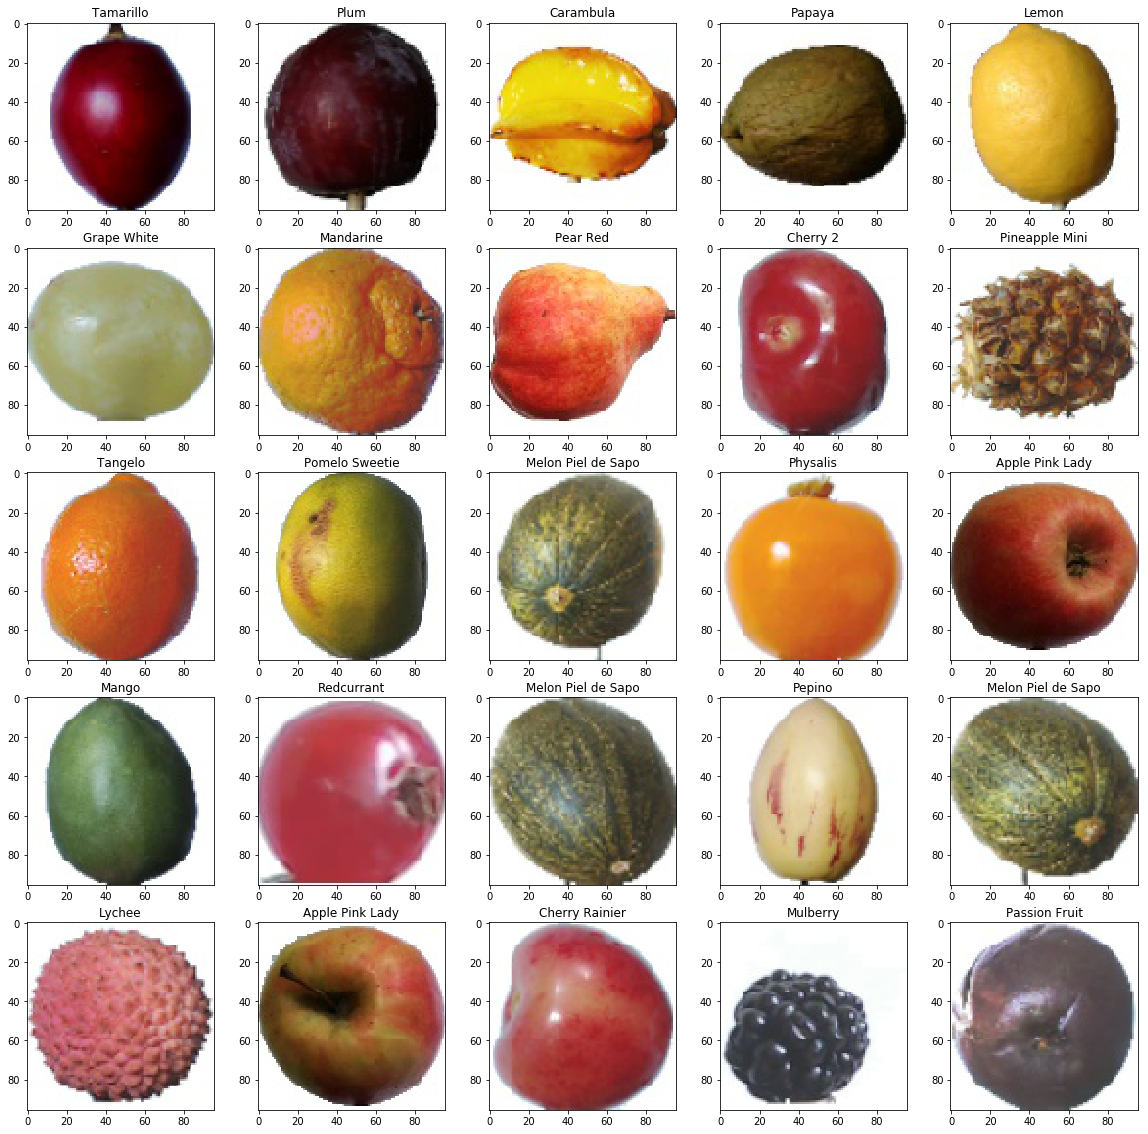

In [0]:
classes = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3","Apple Granny Smith","Apple Pink Lady","Apple Red 1","Apple Red 2","Apple Red 3",
           "Apple Red Delicious","Apple Red Yellow 1","Apple Red Yellow 2","Apricot","Avocado","Avocado ripe","Banana","Banana Lady Finger","Banana Red","Cactus fruit","Cantaloupe 1",
           "Cantaloupe 2","Carambula","Cherry 1","Cherry 2","Cherry Rainier","Cherry Wax Black","Cherry Wax Red","Cherry Wax Yellow","Chestnut","Clementine","Cocos","Dates","Granadilla",
           "Grape Blue","Grape Pink","Grape White","Grape White 2","Grape White 3","Grape White 4","Grapefruit Pink","Grapefruit White","Guava","Hazelnut","Huckleberry","Kaki","Kiwi",
           "Kohlrabi","Kumquats","Lemon","Lemon Meyer","Limes","Lychee","Mandarine","Mango","Mangostan","Maracuja","Melon Piel de Sapo","Mulberry","Nectarine","Orange","Papaya","Passion Fruit",
           "Peach","Peach 2","Peach Flat","Pear","Pear Abate","Pear Kaiser","Pear Monster","Pear Red","Pear Williams","Pepino","Pepper Green","Pepper Red","Pepper Yellow","Physalis",
           "Physalis with Husk","Pineapple","Pineapple Mini","Pitahaya Red","Plum","Plum 2","Plum 3","Pomegranate","Pomelo Sweetie","Quince","Rambutan","Raspberry","Redcurrant","Salak",
           "Strawberry","Strawberry Wedge","Tamarillo","Tangelo","Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Cherry Red","Tomato Maroon","Tomato Yellow","Walnut"]

x_sample, y_sample = sample_generator.next()
plt.rcParams['figure.figsize'] = (20,20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

# Carregando as imagens da base treino e testes
##Utilizaremos 20% da base de treinamento para validação

In [0]:
batch_size = 64

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory("fruits-360/Training",
                                                    target_size = (96, 96),
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory("fruits-360/Training",
                                                         target_size = (96, 96),
                                                         batch_size = batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory("fruits-360/Test",
                                                  target_size = (96, 96),
                                                  batch_size = batch_size,
                                                  class_mode = "categorical")

Found 42569 images belonging to 103 classes.
Found 10608 images belonging to 103 classes.
Found 17845 images belonging to 103 classes.


# Parâmetros para treinamento, validação e teste

In [0]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

batch_size = 64

epochs = 4

steps_per_epoch= validation_generator.samples / batch_size

validation_steps = train_generator.samples / batch_size

test_steps = train_generator.samples / batch_size

patience = epochs // 3

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
df_resultado = pd.DataFrame(columns=["Rede", "train_acc", "val_acc", "test_acc"])
def salvar_resultado(rede, train_acc, val_acc, test_acc, df):
    df = df.append({"Rede" : rede,
                    "train_acc" : train_acc,
                    "val_acc" : val_acc,
                    "test_acc" : test_acc}, ignore_index = True)
    return df

# Rede *Homemade*

## Definindo a rede

In [0]:
home_made = Sequential()

home_made.add(Conv2D(filters = 10,
                     kernel_size = [3, 3],
                     name = "conv_1",
                     activation = "relu",
                     input_shape = [96, 96, 3]))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_1"))

home_made.add(Conv2D(filters = 20,
                     kernel_size = [3, 3],
                     name = "conv_2",
                     activation = "relu"))

home_made.add(Dropout(rate = 0.5,
                      name = "do_1"))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_2"))

home_made.add(Flatten())

home_made.add(Dense(units = 103,
                    name = "dense_1",
                    activation = 'softmax'))

home_made.compile(optimizer = rms,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

home_made.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 94, 94, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 47, 47, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 45, 45, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 45, 45, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 22, 22, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9680)              0         
___________________________

## Treinando o modelo

In [0]:
with tf.device(device):
    history_home_made = home_made.fit_generator(generator = train_generator,
                                                steps_per_epoch = steps_per_epoch,
                                                epochs = epochs,
                                                verbose = 1,
                                                validation_data = validation_generator,
                                                validation_steps = validation_steps,
                                                callbacks=[callbacks.TerminateOnNaN(),
                                                           callbacks.ReduceLROnPlateau(patience = patience),
                                                           callbacks.EarlyStopping(patience = patience,
                                                                                   restore_best_weights = True,
                                                                                   verbose = 1)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/4
166/165 [==============================] - 73s 442ms/step - loss: 2.4640 - acc: 0.4342 - val_loss: 1.8415 - val_acc: 0.66787s - loss: 3.5492 - ETA: 6s - loss:  - ETA: 3s - loss: 2.6 - ETA: 0s - loss: 2.4716 - acc: 0.432
Epoch 2/4
166/165 [==============================] - 71s 425ms/step - loss: 0.6896 - acc: 0.8190 - val_loss: 1.0227 - val_acc: 0.8134 loss: 0.8183 -  - ETA: 9s - loss: 0.8024 - acc: 0 - ETA: 8s - loss: 0.7865 - ETA: 6s - loss: 0.7646 - acc: 0. - ETA: 5s - loss: 0.7554 - acc: 0.8 - ETA: 5s - loss: 0.7510 - acc:  - ETA: 4s - loss: 0.7411 - acc: 0. - ETA: 3s - loss: 0.7316 - acc: - ETA: 2s - loss: 0.7232 - acc: 0.81 - ETA: 2s - loss: 0.72
Epoch 3/4
166/165 [==============================] - 71s 426ms/step - loss: 0.3237 - acc: 0.9114 - val_loss: 0.6960 - val_acc: 0.8663s: 0.40 - ETA: 16s - loss: 0.3960 - acc: 0. - ETA: 16s - loss: 0.3931 - acc: 0. - - ETA: 12s - - ETA: 4s - loss: 0.3395 - acc: 0.90 - ETA: 4s - - ETA

## Imprimindo resultado do treinamento

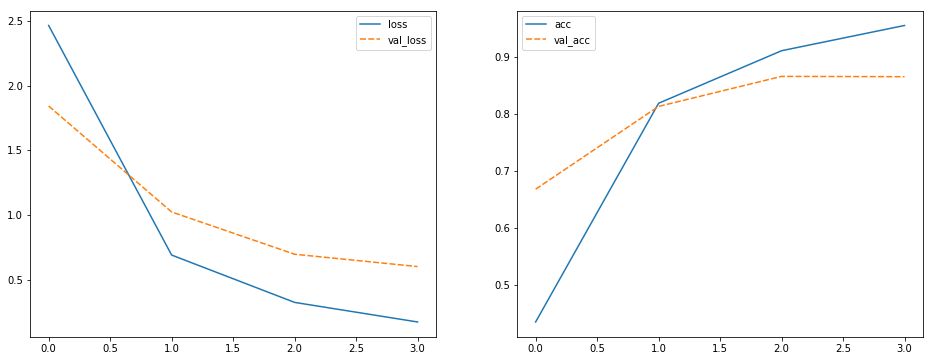

In [0]:
import seaborn as sns

history = pd.DataFrame(history_home_made.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = home_made.evaluate_generator(generator = train_generator,
                                           steps = validation_steps)

score_val = home_made.evaluate_generator(generator = validation_generator,
                                         steps = validation_steps)

score_test = home_made.evaluate_generator(generator = test_generator,
                                          steps = test_steps)

df_resultado = salvar_resultado(rede = "Homemade",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# ResNet18 - Transfer Learning

## Feature Extraction

In [0]:
from classification_models.resnet import ResNet18, preprocess_input

ResNet18_model = ResNet18(input_shape = (96,96,3),
                          weights = "imagenet",
                          include_top=False)

for layer in ResNet18_model.layers:
    layer.trainable = False

output = ResNet18_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

ResNet18_model = Model(inputs = ResNet18_model.input,
                       outputs = output)

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 96, 96, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 48, 48, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = ResNet18_model.fit_generator(generator = train_generator,
                                                  steps_per_epoch = steps_per_epoch,
                                                  epochs = epochs,
                                                  verbose = 1,
                                                  validation_data = validation_generator,
                                                  validation_steps = validation_steps,
                                                  callbacks=[callbacks.TerminateOnNaN(),
                                                             callbacks.ReduceLROnPlateau(patience = patience),
                                                             callbacks.EarlyStopping(patience = patience,
                                                                                     restore_best_weights = True,
                                                                                     verbose = 1)])

Epoch 1/4
166/165 [==============================] - 72s 434ms/step - loss: 1.1132 - acc: 0.7703 - val_loss: 4.8817 - val_acc: 0.0092ss: 1 - ETA: 5s - loss: 1.3593 - acc: 0. - ETA: 5s - loss: 1.3290 - acc: 0.7 - ETA: 4s - loss: 1.3058 - acc: 0.7 - ETA: 4s - loss: 1.2820 - acc: 0 - ETA: 3s - loss: 1.2455 - acc: 0 - ETA: 2s - loss: 1.2099 - acc: 0.75 - ETA: 2s - loss: 1.1964 - acc: 0.753 - ETA: 1s - loss: 1.1897 - acc: 0.754 - ETA: 1s - loss: 1.1826 - 
Epoch 2/4
166/165 [==============================] - 70s 424ms/step - loss: 0.0742 - acc: 0.9858 - val_loss: 4.9994 - val_acc: 0.0092 - loss: 0.1 - ETA: 15s - loss - - ETA: 13s - loss: 0.1072 - a - ETA: 12s - loss: 0.1038 - - ETA: 11s - loss:  - ETA: 5s - loss: 0.0843 - acc: 0 - ETA: 4s - loss: 0.0826 - acc: 0 - ETA: 3s - loss: 0.0814 - - ETA: 2s - loss: 0.0777 - a - ETA: 0s - loss: 0.0752 - acc: 0.
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping


### Imprimindo resultado do treinamento

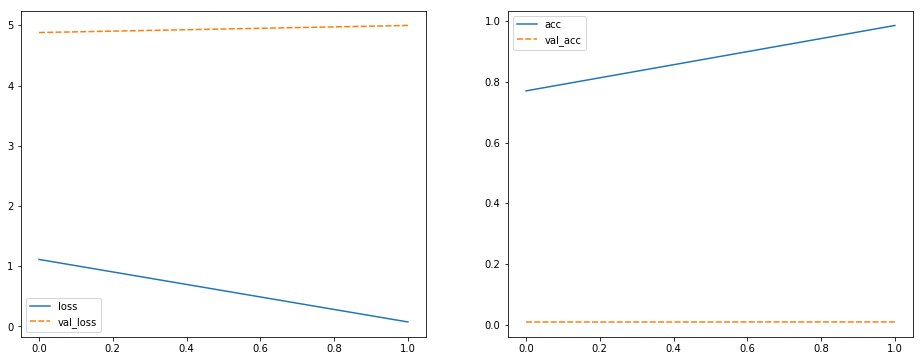

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in ResNet18_model.layers:
    layer.trainable = True

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 96, 96, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 48, 48, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = ResNet18_model.fit_generator(generator = train_generator,
                                                    steps_per_epoch = steps_per_epoch,
                                                    epochs = epochs,
                                                    verbose = 1,
                                                    validation_data = validation_generator,
                                                    validation_steps = validation_steps,
                                                    callbacks=[callbacks.TerminateOnNaN(),
                                                               callbacks.ReduceLROnPlateau(patience = patience),
                                                               callbacks.EarlyStopping(patience = patience,
                                                                                       restore_best_weights = True,
                                                                                       verbose = 1)])

Epoch 1/4
166/165 [==============================] - 75s 450ms/step - loss: 0.0457 - acc: 0.9928 - val_loss: 0.0978 - val_acc: 0.9749 loss: 0.0632 - acc - ETA: 13s - loss: 0.0622 - acc: 0. - ETA: 12s - ETA - ETA: 2s - loss: 0.04
Epoch 2/4
166/165 [==============================] - 72s 432ms/step - loss: 0.0091 - acc: 0.9992 - val_loss: 0.0631 - val_acc: 0.9816
Epoch 3/4
166/165 [==============================] - 71s 429ms/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0661 - val_acc: 0.9822a - ETA: 19s - loss: 0.0047 - acc:  - ETA: 13s - loss: 0.0036 - acc:  - ETA: 13s - loss: 0.0036 - acc:  - ETA - ETA: 10s - loss: 0.0035 - acc:  - ETA: 2s - loss: 0.0029 - acc: 0. - ETA: 2s - loss: 0.0028
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


### Imprimindo resultado do treinamento

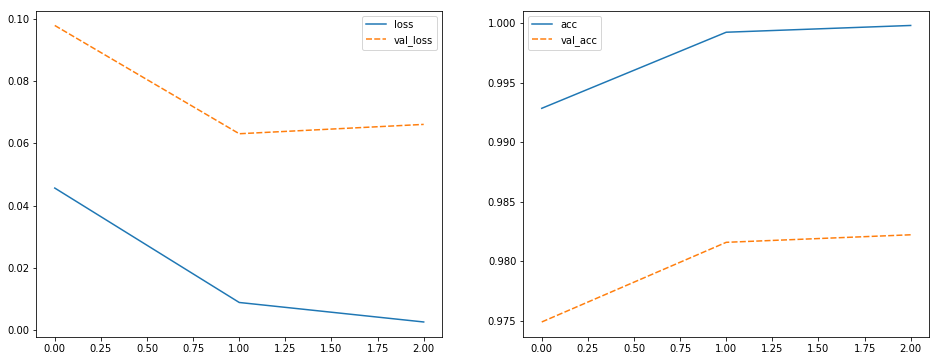

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# VGG16 - Transfer Learning

## Feature Extraction

In [0]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

VGG16_model = VGG16(input_shape = (96,96,3),
                    weights = "imagenet",
                    include_top = False)

for layer in VGG16_model.layers:
    layer.trainable = False

output = VGG16_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

VGG16_model = Model(inputs = VGG16_model.input,
                    outputs = output)

VGG16_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = VGG16_model.fit_generator(generator = train_generator,
                                               steps_per_epoch = steps_per_epoch,
                                               epochs = epochs,
                                               verbose = 1,
                                               validation_data = validation_generator,
                                               validation_steps = validation_steps,
                                               callbacks=[callbacks.TerminateOnNaN(),
                                                          callbacks.ReduceLROnPlateau(patience = patience),
                                                          callbacks.EarlyStopping(patience = patience,
                                                                                  restore_best_weights = True,
                                                                                  verbose = 1)])

Epoch 1/4
166/165 [==============================] - 86s 521ms/step - loss: 4.8754 - acc: 0.0088 - val_loss: 4.8177 - val_acc: 0.0082ETA: 3s - loss: 4.8782 -  - ETA: 1s - loss: 4.8748 - acc
Epoch 2/4
166/165 [==============================] - 84s 506ms/step - loss: 4.7804 - acc: 0.0070 - val_loss: 4.7311 - val_acc: 0.0082cc: 0.006 - ETA: 5s - loss: 4.7971 - acc:  - ETA: 4s - - ETA: 0s - loss: 4.7815 - acc: 0.006 - ETA: 0s - loss: 4.7809 - acc: 0.00
Epoch 3/4
166/165 [==============================] - 84s 507ms/step - loss: 4.7131 - acc: 0.0084 - val_loss: 4.6521 - val_acc: 0.0089a - ETA: 7s - loss: 4.7212 - acc: - ETA: 6s - loss: 4.7201 - acc: 0.0 - ETA: 6s - loss: 4.7203 - acc:  - ETA: 5 - ETA: 0s - loss: 4.7132 - acc: 
Epoch 4/4
166/165 [==============================] - 84s 506ms/step - loss: 4.6182 - acc: 0.0140 - val_loss: 4.5844 - val_acc: 0.0124- a - ETA: 5s - loss: 4.6261 - acc: 0. - ETA: 4s - loss: 4.6255 - acc: 0.01 - ETA: 4s - loss: 4 - ETA: 1s - loss: 4.6203 - 


### Imprimindo resultado do treinamento

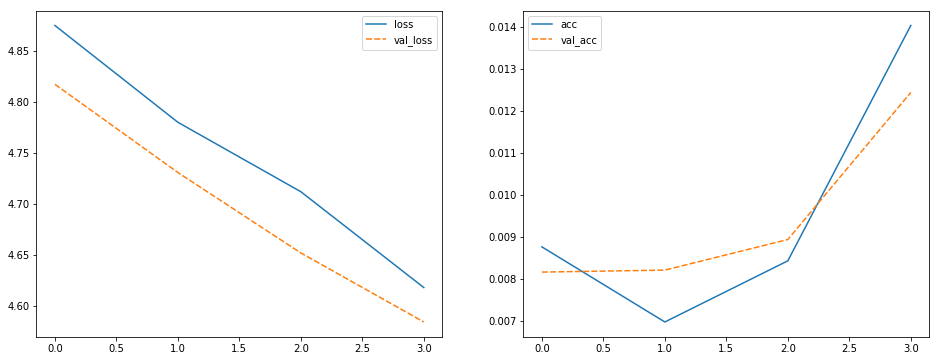

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in VGG16_model.layers:
    layer.trainable = True

VGG16_model.compile(loss ='categorical_crossentropy',
                    optimizer = rms,
                    metrics=['accuracy'])

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = VGG16_model.fit_generator(generator = train_generator,
                                                 steps_per_epoch = steps_per_epoch,
                                                 epochs = epochs,
                                                 verbose = 1,
                                                 validation_data = validation_generator,
                                                 validation_steps = validation_steps,
                                                 callbacks=[callbacks.TerminateOnNaN(),
                                                            callbacks.ReduceLROnPlateau(patience = patience),
                                                            callbacks.EarlyStopping(patience = patience,
                                                                                    restore_best_weights = True,
                                                                                    verbose = 1)])

Epoch 1/4
166/165 [==============================] - 106s 636ms/step - loss: 3.9293 - acc: 0.1454 - val_loss: 3.2105 - val_acc: 0.2719
Epoch 2/4
166/165 [==============================] - 104s 625ms/step - loss: 2.1845 - acc: 0.5117 - val_loss: 1.5556 - val_acc: 0.6218
Epoch 3/4
166/165 [==============================] - 105s 631ms/step - loss: 0.8572 - acc: 0.8121 - val_loss: 0.7665 - val_acc: 0.7942
Epoch 4/4
166/165 [==============================] - 103s 618ms/step - loss: 0.2860 - acc: 0.9425 - val_loss: 0.4437 - val_acc: 0.8685


### Imprimindo resultado do treinamento

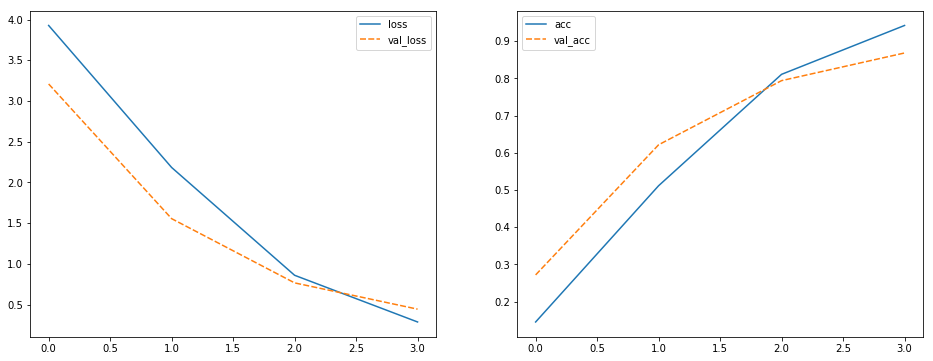

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# InceptionV3 - Transfer Learning

## Feature Extraction

In [0]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

InceptionV3_model = InceptionV3(input_shape = (96,96,3),
                                weights = "imagenet",
                                include_top = False)

for layer in InceptionV3_model.layers:
    layer.trainable = False

output = InceptionV3_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

InceptionV3_model = Model(inputs = InceptionV3_model.input,
                          outputs = output)

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

Epoch 1/4
166/165 [==============================] - 76s 455ms/step - loss: 4.7574 - acc: 0.0116 - val_loss: 5.6897 - val_acc: 0.0110s: 4.7712 - acc: 0.01 - ETA: 27s - loss: 4.7678 - acc:  - ETA:  - ETA: 21s - loss: 4.7634 - acc: 0. - ETA: 21s - loss: 4.7599 - a - ETA: 15s - ETA: 7s - loss: 4.7561 - acc: 0.01 - ETA: 7s - loss: 4.7558 - acc: 0.011 - ETA: 7s - loss: 4.7561 - acc: 0.0 - ETA: 6s - loss: 4.7560 - acc: 0.0 - ETA: 6s - loss: 4.7581 - acc: - ETA: 4s - loss: 4.7578 - acc: 0. - ETA: 4s - loss: 4.7600 - acc - ETA: 2s - loss: 4.7579 - a - ETA: 1s - loss: 4.7578 - acc: 
Epoch 2/4
166/165 [==============================] - 72s 432ms/step - loss: 4.7456 - acc: 0.0111 - val_loss: 5.6734 - val_acc: 0.0106489 - acc: 0.01 - ETA: 16s - loss: 4.7489 - acc - ETA: 16s - loss:  - ETA: 15s -  - ETA: 12s - loss: 4.7511 - acc - ETA: 12s - loss: 4.7523 - acc - ETA: 11s -  - ETA: 9s - loss: 4.7507 - acc: 0 - ETA: 8s - loss: 4.7493 - acc:  - ETA: 7s - loss: 4.7484 - acc:  - ETA: 6s - loss: 4.7489 -

C:\Users\marci\Anaconda3\envs\PythonGPU\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103023). Check your callbacks.
  % delta_t_median)


166/165 [==============================] - 73s 442ms/step - loss: 4.7341 - acc: 0.0120 - val_loss: 5.6555 - val_acc: 0.0115 loss: 4.7369 - acc: 0. - ETA: 9s - loss: 4. - ETA: 6s - loss: 4.7 - ETA: 3s - lo - ETA: 0s - loss: 4.7337 - acc: 0.012
Epoch 4/4
166/165 [==============================] - 72s 436ms/step - loss: 4.7150 - acc: 0.0116 - val_loss: 5.6317 - val_acc: 0.01176s - loss: 4.7219 - acc:  - ETA: 16s - loss: 4.7191 - acc:  - ETA: 16s - loss: 4.7228 - - ETA: 16s - loss: 4.7144 - acc:  - ETA: 16s  - ETA: 15s - loss: 4.7169 - acc: 0.01 - ETA: 15s - lo - ETA: 14s - loss: 4.7170 - a - ETA: 11s - loss: 4.7109 - acc: 0. - ETA: 10s - loss: 4.71 - ETA: 9s - loss: 4.7126 - acc: 0. - ETA: 8s - loss: 4.7136 - acc: 0.01 - ETA: 8s - loss: 4.7133 - acc: 0.0 - ETA: 8s - loss: 4.7141 - acc: 0 - ETA: 7s - loss: 4.7138 - acc - ETA: 6s - ETA: 1s - loss: 4.7129 - acc: 0. - ETA: 1s - loss: 4.7144 - acc: 0.0 - ETA: 0s - loss: 4.7141 - acc: 0.01 - ETA: 0s - loss: 4.7144 - acc: 0.01


### Imprimindo resultado do treinamento

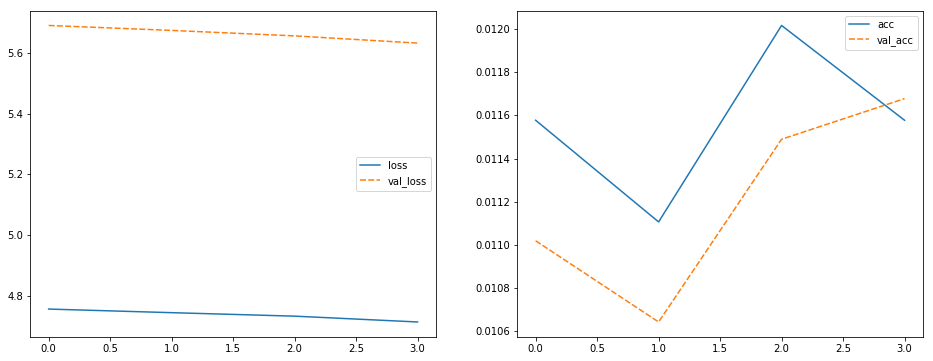

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in InceptionV3_model.layers:
    layer.trainable = True

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                       steps_per_epoch = steps_per_epoch,
                                                       epochs = epochs,
                                                       verbose = 1,
                                                       validation_data = validation_generator,
                                                       validation_steps = validation_steps,
                                                       callbacks=[callbacks.TerminateOnNaN(),
                                                                  callbacks.ReduceLROnPlateau(patience = patience),
                                                                  callbacks.EarlyStopping(patience = patience,
                                                                                          restore_best_weights = True,
                                                                                          verbose = 1)])

Epoch 1/4
166/165 [==============================] - 94s 567ms/step - loss: 4.6459 - acc: 0.0178 - val_loss: 4.5749 - val_acc: 0.0245
Epoch 2/4
166/165 [==============================] - 79s 475ms/step - loss: 4.5575 - acc: 0.0274 - val_loss: 4.5195 - val_acc: 0.0377
Epoch 3/4
166/165 [==============================] - 77s 465ms/step - loss: 4.4732 - acc: 0.0420 - val_loss: 4.4654 - val_acc: 0.0557
Epoch 4/4
166/165 [==============================] - 76s 457ms/step - loss: 4.3863 - acc: 0.0633 - val_loss: 4.3961 - val_acc: 0.0818


### Imprimindo resultado do treinamento

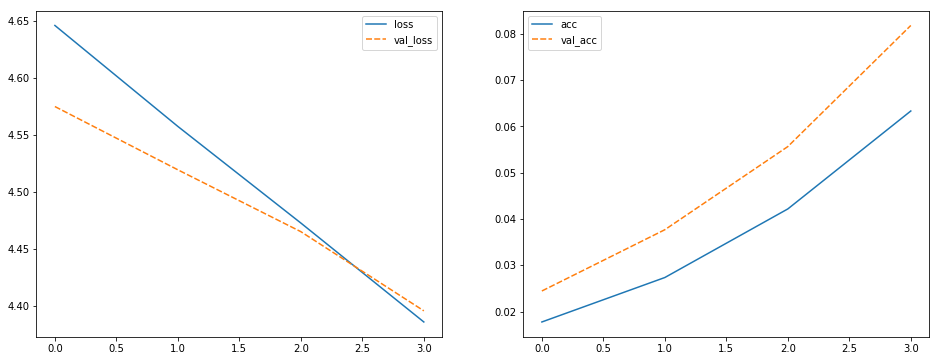

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# MobileNetV2 - Transfer Learning

## Feature Extraction

In [0]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

MobileNet_model = MobileNetV2(input_shape = (96,96,3),
                              weights = "imagenet",
                              include_top = False)

for layer in MobileNet_model.layers:
    layer.trainable = False

output = MobileNet_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

MobileNet_model = Model(inputs = MobileNet_model.input,
                        outputs = output)

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = MobileNet_model.fit_generator(generator = train_generator,
                                                   steps_per_epoch = steps_per_epoch,
                                                   epochs = epochs,
                                                   verbose = 1,
                                                   validation_data = validation_generator,
                                                   validation_steps = validation_steps,
                                                   callbacks=[callbacks.TerminateOnNaN(),
                                                              callbacks.ReduceLROnPlateau(patience = patience),
                                                              callbacks.EarlyStopping(patience = patience,
                                                                                      restore_best_weights = True,
                                                                                      verbose = 1)])

Epoch 1/4
166/165 [==============================] - 79s 477ms/step - loss: 5.5073 - acc: 0.0153 - val_loss: 5.5388 - val_acc: 0.0199s: 5.6943 - ETA: 32s - loss: 5.6970 - acc - ETA: 30s  - ETA: 24s  - ETA: 16s - loss: 5.6487 - - ETA: 14s - loss: 5.6367 - acc:  - ETA: 14s - loss: 5.6331 - acc - ETA: 13s - loss: 5.6307 - - ETA: 12s - loss: 5.6198 - acc - ETA: 11s - loss: 5.6176 - acc:  - ETA: 10s - loss: 5.6063 - acc: 0.01 - ETA: 10s - loss: 5.6087  - ETA: 8s - loss: 5.5960 - a - ETA: 6s - loss: 5.5742 - acc: 0.0 - ETA: 5s - loss: 5.56 - ETA: 2s - loss: 5.53
Epoch 2/4
166/165 [==============================] - 74s 444ms/step - loss: 4.9494 - acc: 0.0360 - val_loss: 5.3905 - val_acc: 0.0237s - ETA: 16s - loss: 5.1623 - ETA: 15s - lo - ETA: 14s - loss: 5.1053 - ETA: 13s - loss - ETA: 11s - loss: 5.0770 - acc:  - ETA: 11s - loss: 5.0768 - acc - ETA: 10s - loss: 5.0678 - acc: 0.03 - ETA: 10s - loss: 5.0669 - acc: 0.03 - ETA: 10s - loss: 5.0651 - a - ETA: 9s - loss: 5.0540 - acc:  - E - ETA: 

### Imprimindo resultado do treinamento

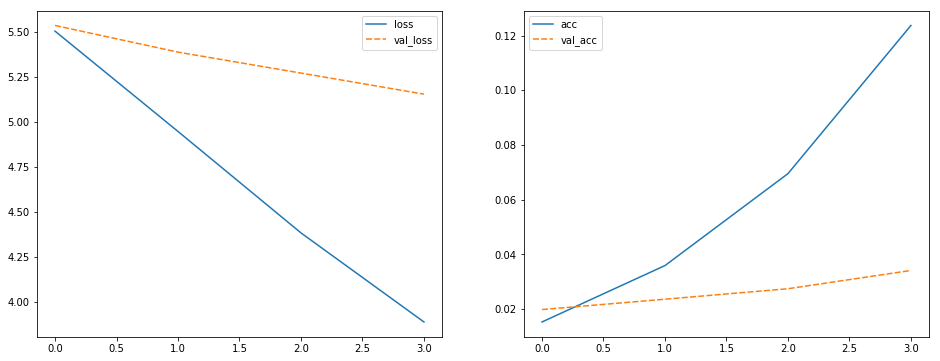

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in MobileNet_model.layers:
    layer.trainable = True

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = MobileNet_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

Epoch 1/4
166/165 [==============================] - 85s 514ms/step - loss: 3.1846 - acc: 0.2474 - val_loss: 2.9130 - val_acc: 0.3070A: 3:13 - loss:  - ETA: 1:08 - loss: 3.5945 - - ETA: 54s - loss: 3.5558 - ETA: 46s - loss: 3.5401 - acc - ETA - ETA: 31s -  - ETA: 25s - loss: 3.4392 - a - ETA: 23s - loss: 3.4286 - ETA: 20s - loss: 3.4159 - acc: 0. - ETA: 1 - ETA: 8s - loss: 3.2813 - acc: 0.2 - ETA: 7s - loss: 3.2741 - acc: 0. - ETA: 6s - loss: 3.2584 - acc: 0.2 - ETA: 5s - loss: 3.2506 - acc: 0.23 - ETA: 5s - loss: 3. - ETA: 1s - loss: 3.1972 - acc: 0. - ETA: 0s - loss: 3.1877 - acc: 0.246
Epoch 2/4
166/165 [==============================] - 76s 458ms/step - loss: 2.4262 - acc: 0.4279 - val_loss: 2.2556 - val_acc: 0.4631s: 2.6046 - acc - ETA: 15s - loss: 2.5959 - ETA: 14s - loss: 2.5876 - acc:  - ETA: 13s - loss: 2.5820 - a - ETA: 12s  - ETA: 10s - loss: 2. - ETA: 7s - loss: 2.5061 - acc: 0 - ETA: 6s - - ETA: 1s - loss: 2.4406 - ac - ETA: 0s - loss: 2.4308 - acc: 0.42
Epoch 3/4
166/165 

### Imprimindo resultado do treinamento

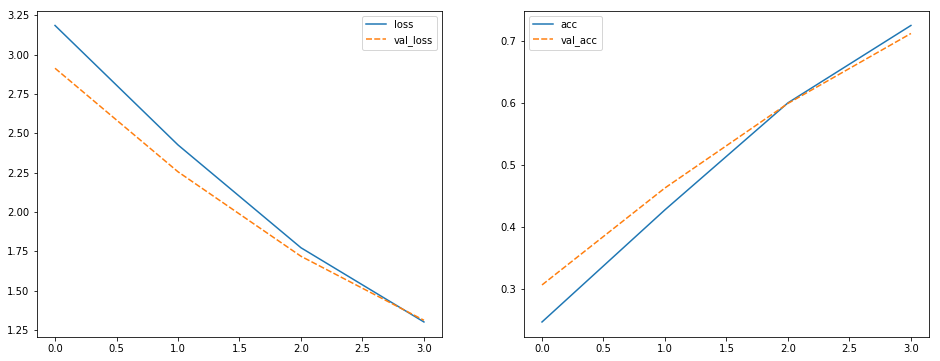

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

In [0]:
df_resultado.sort_values(by=["Rede"])

,Rede,train_acc,val_acc,test_acc
0,Homemade,0.972703,0.866001,0.855922
5,InceptionV3 - Feature Extraction,0.011487,0.011419,0.011247
6,InceptionV3 - Fine Tuning,0.097724,0.082237,0.076992
7,MobileNet - Feature Extraction,0.020907,0.034234,0.023690
8,MobileNet - Fine Tuning,0.819681,0.710221,0.699756
1,ResNet18 - Feature Extraction,0.009303,0.009281,0.009272
2,ResNet18 - Fine Tuning,0.999953,0.981837,0.973844
3,VGG16 - Feature Extraction,0.018417,0.012570,0.024482
4,VGG16 - Fine Tuning,0.972257,0.868703,0.848927
